In [41]:
! python3 -m pip install arch

In [62]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [43]:
companies = '^GSPC'
start     = datetime.datetime(2013, 7, 7)
end       = datetime.datetime(2023, 7, 7)
s_p_500   = yf.download(companies , start=start, end=end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [44]:
s_p_500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-07-08,1634.199951,1644.680054,1634.199951,1640.459961,1640.459961,3514590000
2013-07-09,1642.890015,1654.180054,1642.890015,1652.319946,1652.319946,3155360000
2013-07-10,1651.560059,1657.920044,1647.660034,1652.619995,1652.619995,3011010000
2013-07-11,1657.410034,1676.630005,1657.410034,1675.020020,1675.020020,3446340000
2013-07-12,1675.260010,1680.189941,1672.329956,1680.189941,1680.189941,3039070000


In [45]:
print(s_p_500.pct_change())
percentage_return  = 100 * (s_p_500.pct_change()[1:]['Adj Close'])
realized_volatililty = percentage_return .rolling(5).std()
print(realized_volatililty)

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2013-07-08       NaN       NaN       NaN       NaN        NaN       NaN
2013-07-09  0.005318  0.005776  0.005318  0.007230   0.007230 -0.102211
2013-07-10  0.005277  0.002261  0.002903  0.000182   0.000182 -0.045748
2013-07-11  0.003542  0.011285  0.005917  0.013554   0.013554  0.144579
2013-07-12  0.010770  0.002123  0.009002  0.003086   0.003086 -0.118175
...              ...       ...       ...       ...        ...       ...
2023-06-29  0.001708  0.001831  0.002695  0.004474   0.004474 -0.011411
2023-06-30  0.010857  0.013662  0.011544  0.012269   0.012269  0.061350
2023-07-03  0.006340 -0.000453  0.004488  0.001171   0.001171 -0.481507
2023-07-05 -0.001896 -0.000539 -0.001279 -0.001968  -0.001968  0.711967
2023-07-06 -0.004372 -0.007059 -0.011621 -0.007923  -0.007923  0.057256

[2517 rows x 6 columns]
Date
2013-07-09         NaN
2013-07-10 

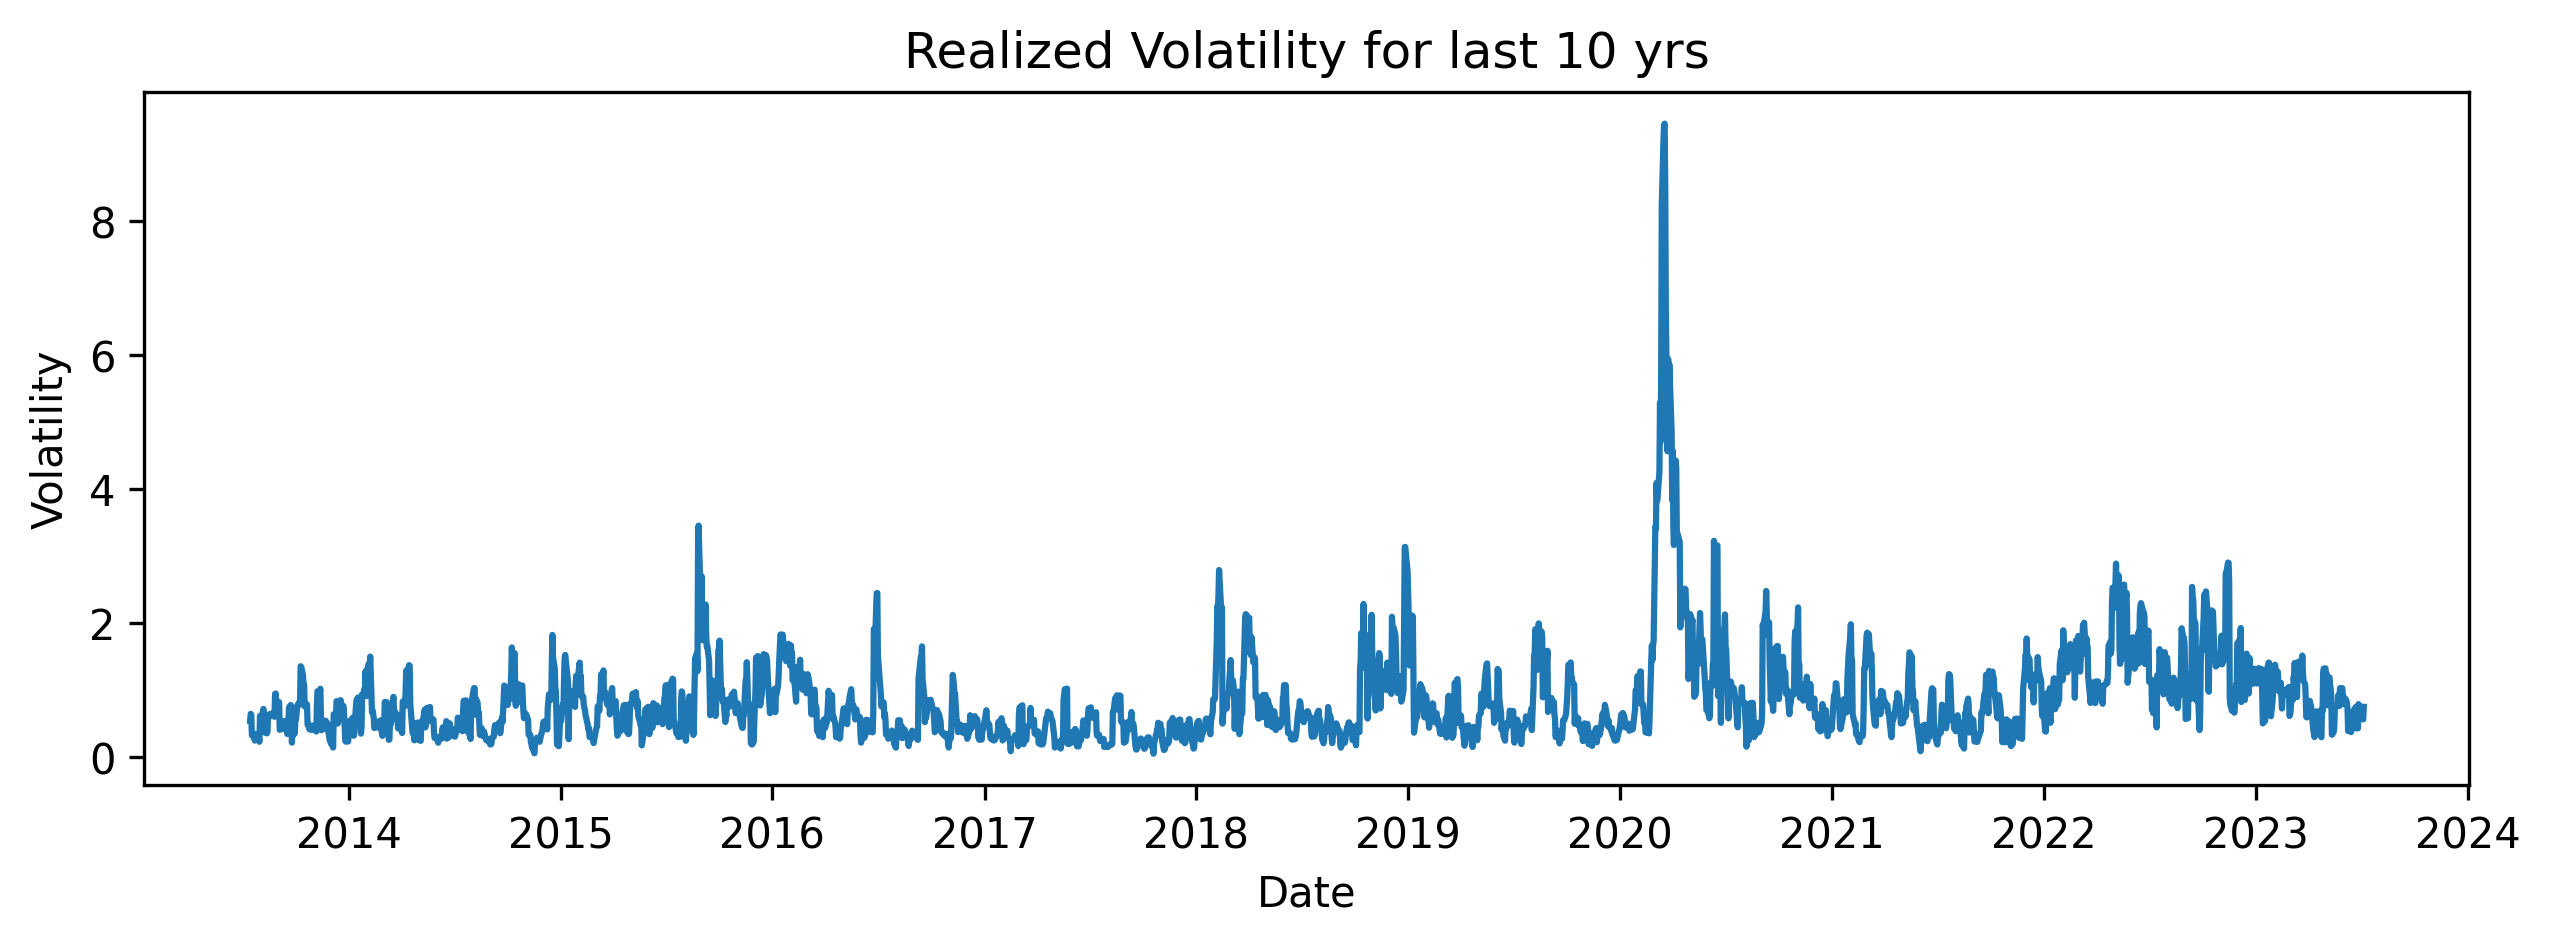

In [46]:
plt.figure(figsize=(10,3))
plt.plot((realized_volatililty).index,(realized_volatililty))
plt.title('Realized Volatility for last 10 yrs')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [47]:
retv = ret.values

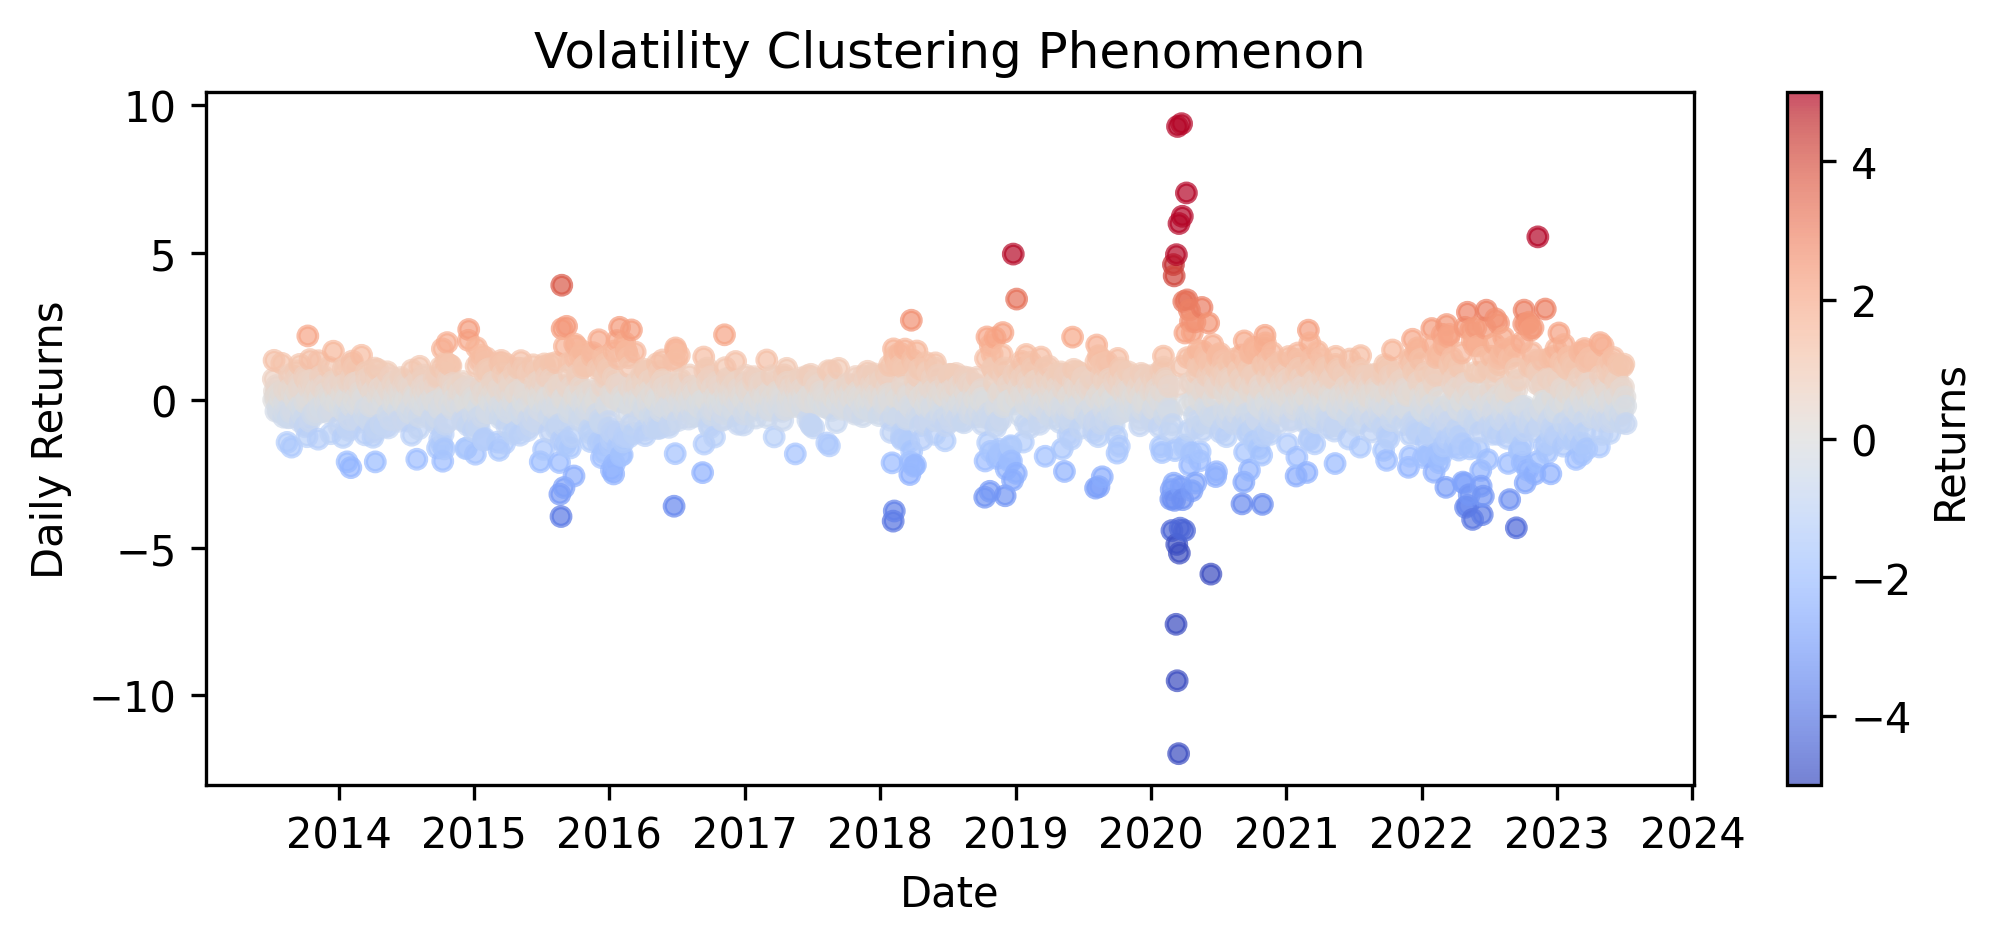

In [48]:

plt.figure(figsize=(8, 3))
plt.scatter(s_p_500.index[1:], percentage_return, s=20, c=percentage_return, cmap='coolwarm', alpha=0.7)
plt.title('Volatility Clustering Phenomenon')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.colorbar(label='Returns')
plt.clim(-5, 5)  # Set the colorbar limits to -5 and 5 for a wider range of colors
plt.show()







In [61]:
n = 200
split_date = percentage_return.iloc[-n:].index
print(split_date)

DatetimeIndex(['2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22',
               '2022-09-23', '2022-09-26', '2022-09-27', '2022-09-28',
               '2022-09-29', '2022-09-30',
               ...
               '2023-06-22', '2023-06-23', '2023-06-26', '2023-06-27',
               '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-03',
               '2023-07-05', '2023-07-06'],
              dtype='datetime64[ns]', name='Date', length=200, freq=None)


In [50]:
sgm2 = percentage_return.var()
K = percentage_return.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 *
                             (3.0 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(0.6676173817574015, 0.4618897554983908)

In [51]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks

In [52]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1222.482858926517

In [53]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                              method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
          .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [54]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1190.6509033400453
             x: [ 6.366e-01  5.040e-01]
           nit: 29
          nfev: 55
 final_simplex: (array([[ 6.366e-01,  5.040e-01],
                       [ 6.366e-01,  5.041e-01],
                       [ 6.366e-01,  5.041e-01]]), array([ 1.191e+03,  1.191e+03,  1.191e+03]))

Resulting params = [0.63662497 0.50403718]


In [55]:
def arch_apply(ret):
        omega = params[0]
        alpha = params[1]
        T = len(ret)
        sigma2_arch = np.zeros(T + 1)
        sigma2_arch[0] = np.var(ret)
        for t in range(1, T):
            sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
        return sigma2_arch

In [56]:
sigma2_arch = arch_apply(ret)

In [57]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3502.60
Distribution:                  Normal   AIC:                           7009.19
Method:            Maximum Likelihood   BIC:                           7020.85
                                        No. Observations:                 2516
Date:                Sun, Jul 09 2023   Df Residuals:                     2516
Time:                        12:48:13   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6365  4.125e-02     15.432  1.001e-53 [  0.556,  0.71

In [58]:
bic_arch = []

for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3229.41
Distribution:                  Normal   AIC:                           6468.82
Method:            Maximum Likelihood   BIC:                           6497.97
                                        No. Observations:                 2516
Date:                Sun, Jul 09 2023   Df Residuals:                     2516
Time:                        12:48:13   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2581  2.769e-02      9.319  1.175e-20   [  0.20

In [59]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):]
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1065


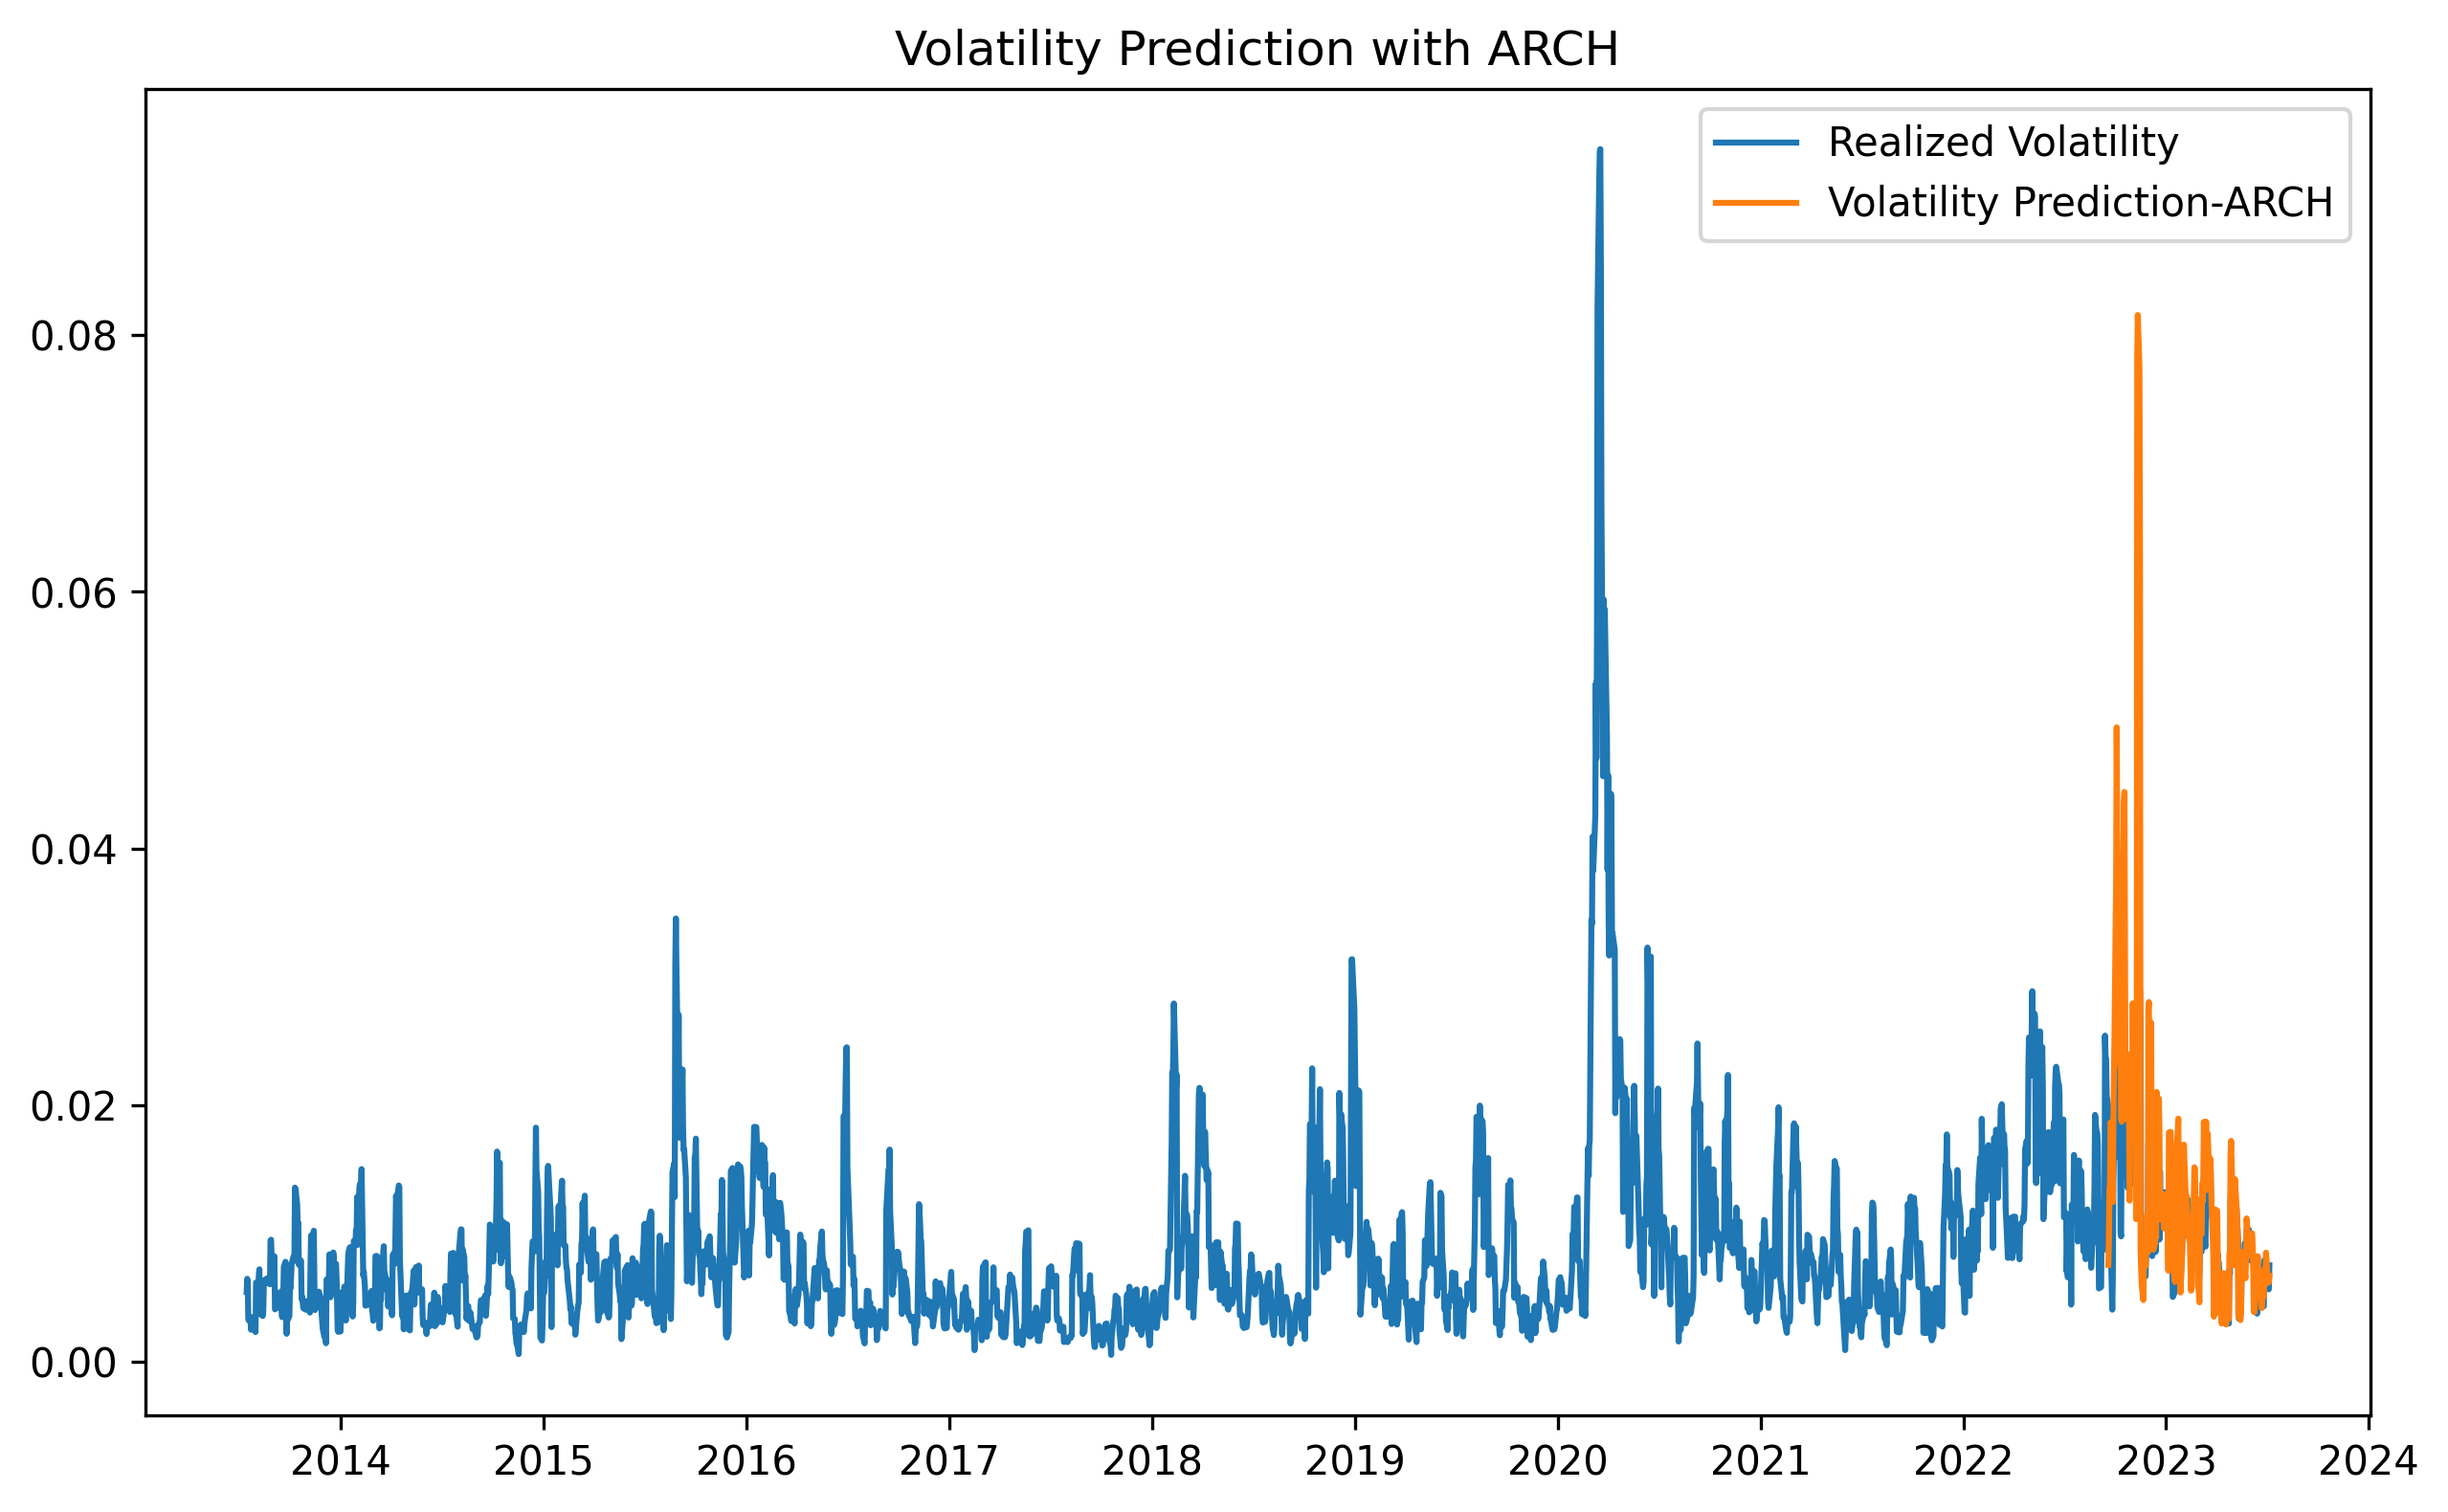

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()